# COURSE: A deep understanding of deep learning
## SECTION: More on data
### LECTURE: CodeChallenge: unbalanced data
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/dudl/?couponCode=202201

In [1]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import and process the data

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep=';')
# Remove rows with outliers
data = data[data['total sulfur dioxide']<200]

# Z-SCORE ALL VARIABLES EXCEPT FOR QUALITY
# Find the columns we want to normalize (all except quality)
cols_2_zscore = data.keys()
cols_2_zscore = cols_2_zscore.drop('quality')
data[cols_2_zscore] = data[cols_2_zscore].apply(stats.zscore)

# A function to process the data by quality metric



In [3]:
def create_a_dataset(qual_threshold):

    # Create a new column for binarized (boolean) quality
    data['boolQuality'] = 0

    temp = (data['quality'] > qual_threshold).astype(int)
    data['boolQuality'] = temp

    # Convert from pandas dataframe to tensor
    dataT  = torch.tensor(data=data[cols_2_zscore].values).float()
    labels = torch.tensor(data=data['boolQuality'].values).float()
    labels = labels[:, None] # Transform to matrix. We'll actually need the labels to be a "tensor"

    # Use scikitlearn to split the data
    train_data, test_data, train_labels, test_labels = \
        train_test_split(dataT, labels, test_size=0.1)

    # Convert into PyTorch Datasets
    train_data_set = TensorDataset(train_data, train_labels)
    test_data_set  = TensorDataset(test_data, test_labels)

    # Translate into Dataloader objects
    batch_size   = 8
    train_loader = DataLoader(dataset=train_data_set, batch_size=batch_size,
                            shuffle=True, drop_last=True)
    test_loader  = DataLoader(dataset=test_data_set, 
                          batch_size=test_data_set.tensors[0].shape[0])
    
    return train_loader, test_loader

In [4]:
# Test the dataset and the number of samples

# Note that the data are roughly balanced with thresh=5, not 4 or 6
train_loader, test_loader = create_a_dataset(qual_threshold=6)

# Get number of high/low quality wines
quality_ratings = train_loader.dataset.tensors[1].detach()
print(f'{torch.sum(quality_ratings == 0).item()} low-rated wines')
print(f'{torch.sum(quality_ratings == 1).item()} high-rated wines')

1245 low-rated wines
192 high-rated wines


# The DL parts: class for the model, and a function to train it

In [5]:
class ANN_wine(nn.Module):
  """
  DATA_ UNBALANCED DATA
  """
  def __init__(self):
    super().__init__()

    # LAYERS
    # Input layer
    self.input = nn.Linear(11, 16)

    # Hidden layer(s). 'fc' = fully connected
    self.fc1 = nn.Linear(16, 32)
    self.fc2 = nn.Linear(32, 32)

    # Output layer
    self.output = nn.Linear(32, 1)
  
  # Forward pass
  def forward(self, x):
    x = F.leaky_relu(self.input(x))
    x = F.leaky_relu(self.fc1(x))
    x = F.leaky_relu(self.fc2(x))

    return self.output(x)

In [6]:
# Global parameter
num_epochs = 500

def train_the_model():
  """
  DATA_ UNBALANCED DATA
  """

  loss_func = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.Adam(wine_net.parameters(), lr=0.001)

  # Initialize accuracies as empties
  train_acc = []
  test_acc  = []
  losses = torch.zeros(num_epochs)

  # Loop over epochs
  for epoch_i in range(num_epochs):

    # Loop over training data batches
    batch_acc = []
    batch_loss = []

    for X, y in train_loader:

      # Forward pass and loss
      y_hat = wine_net(X)
      loss  = loss_func(y_hat, y)

      # Backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Compute training accuracy just for this batch
      batch_acc.append(100 * torch.mean(((y_hat > 0) == y).float()).item())

      # Loss from this batch
      batch_loss.append(loss.item())

    # End of batch loop...

    # Now that we've trained through the batches, get their average training accuracy 
    train_acc.append(np.mean(batch_acc))

    # Get average losses across the batches
    losses[epoch_i] = np.mean(batch_loss)

    # Test accuracy (NOTE: testing in batches!)    
    X, y = next(iter(test_loader))  # Extract x,y from test dataloader
    with torch.no_grad():           # Deactivates autograd
      pred_labels = wine_net(X)

    # Compute accuracy
    test_acc.append(100 * torch.mean(((pred_labels > 0) == y).float()).item())

  # Function output
  return train_acc, test_acc, losses

In [7]:
# Create the data
train_loader, test_loader = create_a_dataset(qual_threshold=5)

# Create a model and train it
wine_net = ANN_wine()
train_acc, test_acc, losses = train_the_model()

# Compute accuracy per quality type
X, y = next(iter(test_loader))
y_hat = wine_net(X)
item_accuracy = ((y_hat > 0) == y).float()

per_qual_acc = [100 * torch.mean(item_accuracy[y == 0]),
                100 * torch.mean(item_accuracy[y == 1])]

per_qual_acc

[tensor(73.8095), tensor(82.8947)]

# Now run the entire experiment!

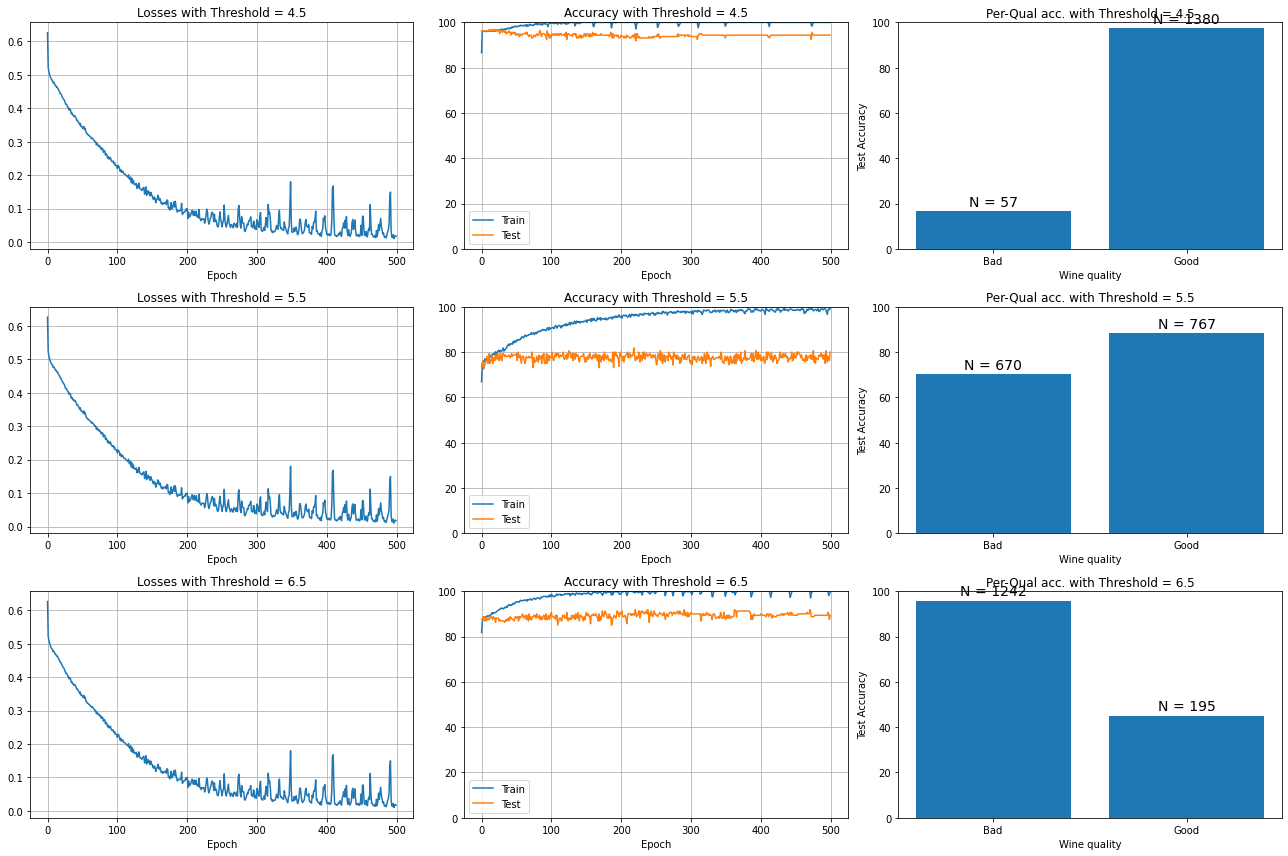

In [12]:
# Setup the figure
fig, ax = plt.subplots(3, 3, figsize=(18, 12))

# The quality thresholds
quality_thresholds = [4, 5, 6]

# Loop over quality thresholds
for qual_thres_idx in range(len(quality_thresholds)):

    # Create the data and model, and train it
    train_loader, test_loader = create_a_dataset(qual_threshold=quality_thresholds[qual_thres_idx])
    wine_net                  = ANN_wine()
    train_acc, test_acc, loss = train_the_model()

    # Compute accuracy per quality type
    X, y          = next(iter(test_loader))
    item_accuracy = ((wine_net(X) > 0) == y).float()
    per_qual_acc  = [100 * torch.mean(item_accuracy[y == 0]),
                     100 * torch.mean(item_accuracy[y == 1])]

    # Plot losses
    ax[qual_thres_idx, 0].plot(losses)
    ax[qual_thres_idx, 0].set_title(f'Losses with Threshold = {quality_thresholds[qual_thres_idx] + 0.5}')
    ax[qual_thres_idx, 0].set_xlabel('Epoch')
    ax[qual_thres_idx, 0].grid()

    # Plot overall accuracy
    ax[qual_thres_idx, 1].plot(train_acc, label='Train')
    ax[qual_thres_idx, 1].plot(test_acc,  label='Test')
    ax[qual_thres_idx, 1].set_title(f'Accuracy with Threshold = {quality_thresholds[qual_thres_idx] + 0.5}')
    ax[qual_thres_idx, 1].legend()
    ax[qual_thres_idx, 1].set_xlabel('Epoch')
    ax[qual_thres_idx, 1].set_ylim([0, 100])
    ax[qual_thres_idx, 1].grid()

    # Plot the per-quality accuracy
    bh = ax[qual_thres_idx, 2].bar(['Bad', 'Good'], per_qual_acc)
    ax[qual_thres_idx, 2].set_ylim([0, 100])
    ax[qual_thres_idx, 2].set_xlabel('Wine quality')
    ax[qual_thres_idx, 2].set_ylabel('Test Accuracy')
    ax[qual_thres_idx, 2].set_title(f'Per-Qual acc. with Threshold = {quality_thresholds[qual_thres_idx] + 0.5}')

    # Print the counts on top of each bar
    for i, r in enumerate(bh):
        N = torch.sum(train_loader.dataset.tensors[1] == i).item()
        ax[qual_thres_idx, 2].text(r.get_x() + r.get_width()/2, r.get_height() + 1,
                                    f'N = {N}', ha='center', va='bottom', fontsize=14)

plt.tight_layout()
plt.show()

# Additional explorations
1) L2 regularization is supposed to help minimize over-training. Try adding an L2 regularizer and see if that
   helps reduce the bias due to unbalanced N.

2) Does the unbalanced design get better (that is, less unbalanced) if the train/test split is 80/20 instead of 90/10?
   Try it and find out! Note that you don't need to train models for this question; you simply need to modify the data
   splitting function and then compute the proportions of the two categories.